In [12]:
# imports
import pystac_client
import xarray as xr
import matplotlib.pyplot as plt
import pathlib
import os
import numpy as np
import geopandas as gpd
import matplotlib as mpl
from matplotlib import colors
from shapely import wkb

In [2]:
# opening STAC catalog, either a url, cloud storage link or a local (cloned) folder
cwd = pathlib.Path().resolve()

catalog = pystac_client.Client.open(
    "https://storage.googleapis.com/dgds-data-public/gca/gca-stac2/catalog.json" # cloud API
    #os.path.join(os.path.dirname(cwd), "stac_folder", "current", "catalog.json") # local clone 
)
#catalog

c:\Users\kras\AppData\Local\mambaforge\envs\coclico_new\Lib\site-packages\pystac_client\client.py:186: NoConformsTo: Server does not advertise any conformance classes.
  warnings.warn(NoConformsTo())


In [3]:
list(catalog.get_children())

[<CollectionClient id=shore_mon_fut>,
 <CollectionClient id=sed_class>,
 <CollectionClient id=shore_mon>,
 <CollectionClient id=world_pop>,
 <CollectionClient id=world_gdp>,
 <CollectionClient id=shore_mon_hr>,
 <CollectionClient id=shore_mon_drivers>,
 <CollectionClient id=esl_gwl>,
 <CollectionClient id=sub_threat>]

In [4]:
href = catalog.get_child("sub_threat").assets["data"].href

In [17]:
ds = xr.open_zarr(href)
ds

<xarray.Dataset>
Dimensions:   (stations: 108, time: 2)
Coordinates:
    country   (stations) |S26 dask.array<chunksize=(108,), meta=np.ndarray>
    geometry  (stations) |S1095835 dask.array<chunksize=(1,), meta=np.ndarray>
    lat       (stations) float64 dask.array<chunksize=(108,), meta=np.ndarray>
    lon       (stations) float64 dask.array<chunksize=(108,), meta=np.ndarray>
  * time      (time) int32 2010 2040
Dimensions without coordinates: stations
Data variables:
    eapa      (time, stations) float64 dask.array<chunksize=(2, 108), meta=np.ndarray>
    egdp      (time, stations) float64 dask.array<chunksize=(2, 108), meta=np.ndarray>
    epsi      (time, stations) float64 dask.array<chunksize=(2, 108), meta=np.ndarray>
Attributes: (12/21)
    AUTHOR:              Herrera, G., Ezquerro, P., Tomás, R., Bejar, M., Lop...
    CITATION:            Herrera, G. & Ezquerro, Pablo & Tomás, Roberto & Bej...
    COMMENT:             
    CRS:                 EPSG:4326
    Conventions:         CF-1.8
    DESCRIPTION:         Subsidence, the lowering of Earth's land surface, is...
    ...                  ...
    SPATIAL_EXTENT:      [-180, -90, 180, 90]
    TAGS:                ['land subsidence', 'groundwater depletion', 'drought']
    TEMPORAL_EXTENT:     ['2010', '2040']
    TITLE:               Land Subsidence Threat
    TITLE_ABBREVIATION:  sub_threat
    UNITS:

In [88]:
# plot input params
var = "epsi" # look at ds's data variables for options
time = 2010 # look at ds.time.values for options

# world shapefile
shapefile = r'p:\11208003-latedeo2022\020_InternationalDeltaPortfolio\datasets\05_world-administrative-boundaries\world-administrative-boundaries.shp'
world = gpd.read_file(shapefile)

In [31]:
# make geodataframe by converting wkb back to polygons
df = ds[var].sel(time=time).to_dataframe().reset_index()
geometry = [wkb.loads(i) for i in df.geometry]
gdf = gpd.GeoDataFrame(df, geometry=geometry)

In [93]:
ds[var].long_name

'Potential subsidence index'

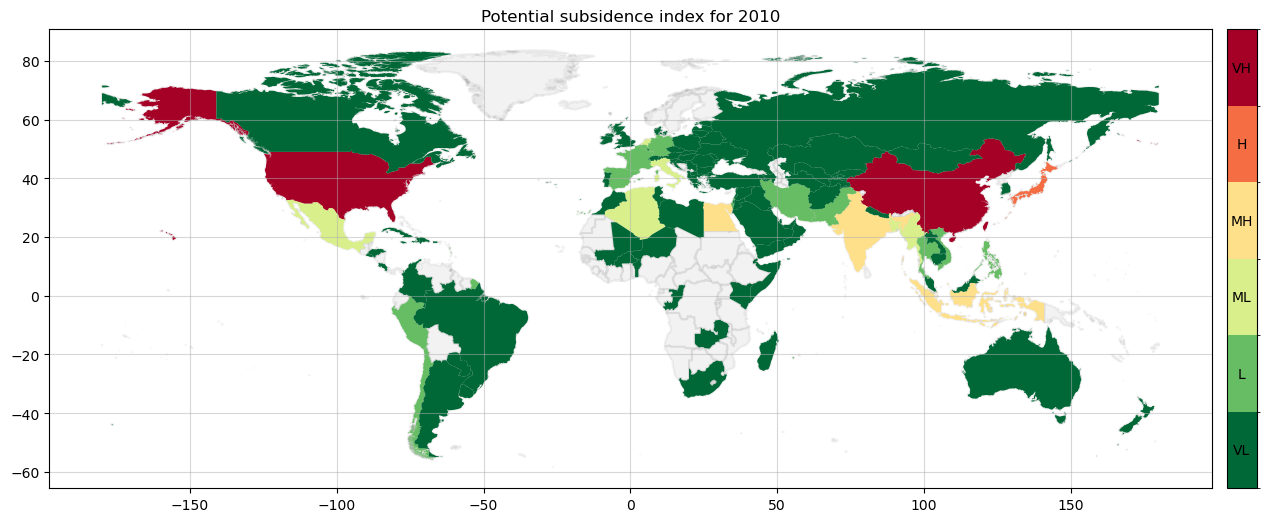

In [109]:
# settings
vmin = 0
vmax = 61
steps = 7

# plotting
cmap = mpl.cm.RdYlGn_r
norm = colors.BoundaryNorm(np.linspace(vmin, vmax, steps), cmap.N)
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
base = world.boundary.plot(ax=ax, edgecolor='grey',facecolor='grey',alpha=0.1,zorder=0)
plot = gdf.plot(var, ax=ax, cmap=cmap, norm=norm)
ax.grid(alpha=0.5)
ax.set_title("%s for %s"%(ds[var].long_name, time))

cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height]) # to give colorbar own axes
cb = plt.colorbar(cbar, cax=cax) # Similar to fig.colorbar(im, cax = cax)
cb.set_ticks([])
for j, lab in enumerate(['VL','L','ML','MH','H','VH']):
    cb.ax.text(.5, vmin+((vmax-vmin)/(steps-1))*j+((vmax-vmin)/(steps-1))/2, lab, ha='center', va='center')
cb.ax.get_yaxis().labelpad = 15
#cb.set_label('Potential Subsidence Index (Very Low to Very High)');

In [106]:
print(np.min(df[var].values))
print(np.max(df[var].values))

0.0
60.786857759586766
